# Effect of epistasis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


In [2]:
predicted_dataset = pd.read_csv('../data/fitness_data.csv')
# Ensure 'geno' column is of type string
predicted_dataset['geno'] = predicted_dataset['geno'].astype(str)
# Pad 'geno' strings with leading zeros to get 15-digit binary
predicted_dataset['binary'] = predicted_dataset['geno'].apply(lambda x: x.zfill(15))
#geni to a list of integers
predicted_dataset['binary'] = predicted_dataset['binary'].apply(lambda x: [int(i) for i in x])


In [3]:
predicted_dataset.columns


Index(['new_fitness', 'mutations_x', 'geno', 'genotype', 'delta',
       'mutations_y', 'delta_3D', 'average_date', 'log10Kd_ACE2',
       'log10Kd_CB6', 'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309',
       's', 'binary', 'real_f', 'ln_Kd_ACE2', 'ln_Kd_CB6', 'ln_Kd_CoV555',
       'ln_Kd_REGN10987', 'ln_Kd_S309', 'pred_f', 'encoding', 'median',
       'average', 'q10', 'q25', 'q01', 'count', 'n_mutations', 'binary_epi'],
      dtype='object')

In [4]:
predicted_dataset['real_f']=predicted_dataset['s']+1
T=1.6
def logistic_model(x, a, C, K_1, K_2, K_3, K_4):
    return a * (1+C * np.exp(x[0]/T)) / (C * np.exp(x[0]/T) + K_1 * np.exp(x[1]/T) + K_2 * np.exp(x[2]/T) + K_3 * np.exp(x[3]/T) + K_4 * np.exp(x[4]/T) + 1)
parameter_bounds = ([0, 0, 0, 0, 0, 0],
                    [np.inf, np.inf, np.inf, np.inf, np.inf , np.inf])
initial_guess = [1,  1e-8, 1e-8, 1e-8, 1e-8, 1e-8]
features = ['log10Kd_ACE2', 'log10Kd_CB6',
            'log10Kd_CoV555', 'log10Kd_REGN10987', 'log10Kd_S309']

for feature in features:
    # Create new column name by removing 'log10' and appending 'ln'
    new_column_name = 'ln_' + feature[5:]

    # Calculate natural logarithm by multiplying log to base 10 value by ln(10)
    predicted_dataset[new_column_name] = predicted_dataset[feature] * np.log(10)

ln_features = ['ln_Kd_ACE2', 'ln_Kd_CB6',
               'ln_Kd_CoV555', 'ln_Kd_REGN10987', 'ln_Kd_S309']


predicted_dataset_existing=predicted_dataset[predicted_dataset['count']>0]
mu='S:T478K'
df_without = predicted_dataset[~predicted_dataset['mutations_x'].apply(lambda x: mu in x)]
#keep only points with 'S:T478K' in mutations_x
df_with = predicted_dataset[predicted_dataset['mutations_x'].apply(lambda x: mu in x)]
df_without_existing = predicted_dataset_existing[~predicted_dataset_existing['mutations_x'].apply(lambda x: mu in x)]
df_with_existing = predicted_dataset_existing[predicted_dataset_existing['mutations_x'].apply(lambda x: mu in x)]

#print all len
print('len of df_without:',len(df_without))
print('len of df_with:',len(df_with))
print('len of df_without_existing:',len(df_without_existing))
print('len of df_with_existing:',len(df_with_existing))

len of df_without: 16384
len of df_with: 16384
len of df_without_existing: 363
len of df_with_existing: 758


In [5]:
X_train_without = df_without_existing[ln_features].values
X_test_without = df_without[ln_features].values
y_train_without = df_without_existing['real_f'].values

# Create and train the logistic
parameters, _ = curve_fit(logistic_model, X_train_without.T, y_train_without, p0=initial_guess,
                            bounds=parameter_bounds, method='trf', maxfev=1000000)
# Extract the fitted parameters
a, C, K_1, K_2, K_3, K_4 = parameters
y_pred_without = logistic_model(X_test_without.T, a, C, K_1, K_2, K_3, K_4)
df_without['pred_f']=y_pred_without



X_train_with = df_with_existing[ln_features].values
X_test_with = df_with[ln_features].values
y_train_with = df_with_existing['real_f'].values

# Create and train the logistic
parameters, _ = curve_fit(logistic_model, X_train_with.T, y_train_with, p0=initial_guess,
                            bounds=parameter_bounds, method='trf', maxfev=1000000)
# Extract the fitted parameters
a, C, K_1, K_2, K_3, K_4 = parameters
y_pred_with = logistic_model(X_test_with.T, a, C, K_1, K_2, K_3, K_4)
df_with['pred_f']=y_pred_with



#concatenate df_with and df_without in predicted_dataset
predicted_dataset=pd.concat([df_with,df_without])



C:\Users\12162\AppData\Local\Temp\ipykernel_22604\1188145236.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without['pred_f']=y_pred_without
C:\Users\12162\AppData\Local\Temp\ipykernel_22604\1188145236.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with['pred_f']=y_pred_with


In [6]:
mutation_names = ['G339D', 'S371L', 'S373P', 'S375F', 'K417N', 'N440K', 'G446S', 'S477N',
                  'T478K', 'E484A', 'Q493R', 'G496S', 'Q498R', 'N501Y', 'Y505H']

# Predicted vs science

C:\Users\12162\AppData\Local\Temp\ipykernel_22604\1973991506.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  predicted_dataset['n_mutations'][0]=0
C:\Users\12162\AppData\Local\Temp\ipykernel_22604\1973991506.py:3: SettingWithCopyWarning:

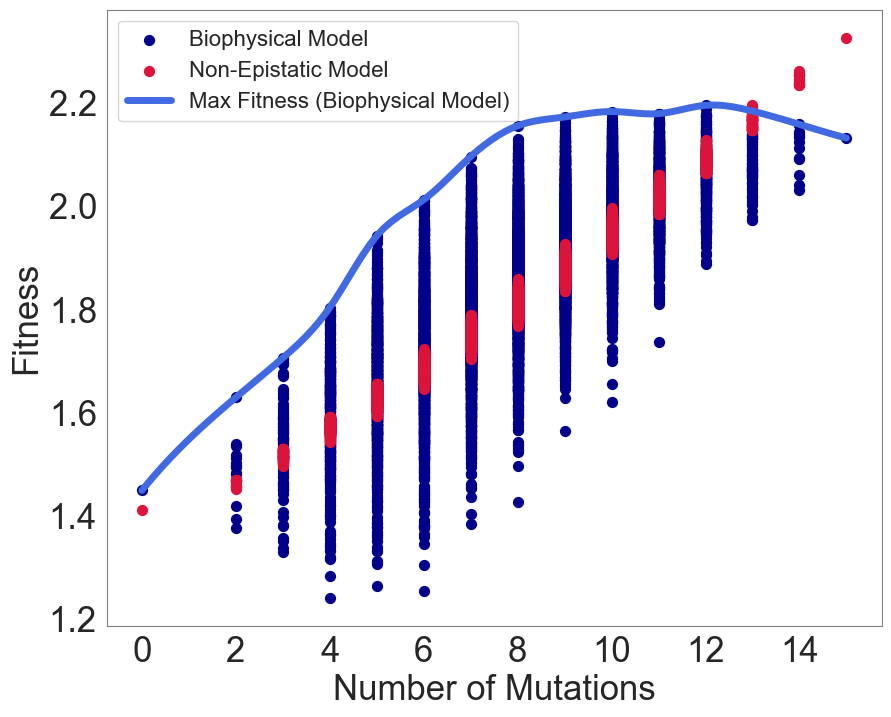

In [7]:
predicted_dataset['n_mutations'] = predicted_dataset['mutations_x'].apply(lambda x: len(x.split(',')))
#set n mutations=0 for first line for wildtype
predicted_dataset['n_mutations'][0]=0
mut='S:T478K'
df_without = predicted_dataset[~predicted_dataset['mutations_x'].apply(lambda x: mut in x)]
#keep only points with 'S:T478K' in mutations_x
df_with = predicted_dataset[predicted_dataset['mutations_x'].apply(lambda x: mut in x)]


fig, ax = plt.subplots(figsize=(10, 8))
df_with.plot.scatter(x='n_mutations', y='pred_f', c='DarkBlue', alpha=1, label='Biophysical Model', ax=ax, s=50)
df_with.plot.scatter(x='n_mutations', y='real_f', c='Crimson', alpha=1, label='Non-Epistatic Model', ax=ax, s=50)

max_with = df_with.groupby('n_mutations')['pred_f'].max()
max_without = df_without.groupby('n_mutations')['pred_f'].max()
x_with = max_with.index
y_with = max_with.values
spline_with = interp1d(x_with, y_with, kind='cubic')

max_real_with = df_with.groupby('n_mutations')['real_f'].max()
x_real_with = max_real_with.index
y_real_with = max_real_with.values
spline_real_with = interp1d(x_real_with, y_real_with, kind='cubic')

# Create a smoother curve for plotting
x_smooth_with = np.linspace(x_with.min(), x_with.max(), 100)
# Plot the curved lines connecting the quantile values
plt.plot(x_smooth_with, spline_with(x_smooth_with), color='RoyalBlue', linestyle='-', linewidth=5, label='Max Fitness (Biophysical Model)')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('Number of Mutations', fontsize=25)
plt.ylabel('Fitness', fontsize=25)
plt.legend(fontsize=16)

ax.grid(False)
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray') 
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')

plt.savefig('../paper/log_F_vs_mu.png', dpi=300)
plt.show()


# Linear regression model witout epistasis

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict

In [10]:
#first-order model 
#Create 10 folds with 90/10 split
kf = KFold(n_splits=10, shuffle=True, random_state=42)
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
scores_1st = cross_val_score(regr, predicted_dataset['binary'].to_list(), predicted_dataset['pred_f'].to_list(), cv=kf)
print("Cross-validated scores:", scores_1st)
# The coefficients
regr_1st=LinearRegression()
regr_1st.fit(predicted_dataset['binary'].to_list(), predicted_dataset['pred_f'].to_list())


Cross-validated scores: [0.95869792 0.9592115  0.95632063 0.95745886 0.9556068  0.95982362
 0.95966502 0.95954047 0.95716064 0.95666456]


LinearRegression()

# Epistasis

In [11]:
def g_to_epi(g):
    """Takes a genotype and returns the augmented genotype (epistasis)"""
    epi=[]
    for i in range(len(g)):
        for j in range(i,len(g)):
            epi.append(g[i]*g[j])
    return epi
def g_to_matrix(g):
    """Takes a genotype and returns the corresponding epistasis matrix"""
    matrix = np.zeros((15,15))
    for i in range(15):
        for j in range(15):
            matrix[i,j] = g[i]*g[j]
    return matrix

def epi_to_matrix(epi):
    """Takes an augmented genotype and returns the corresponding epistasis matrix"""

    matrix = np.zeros((15,15))
    n=0
    for i in range(15):
        for j in range(i,15):
            matrix[i,j] = epi[n]
            matrix[j,i] = epi[n]
            n+=1
    return matrix



    


In [12]:
predicted_dataset['binary_epi'] = predicted_dataset['binary'].apply(lambda x: g_to_epi(x))


In [13]:

# Create 10 folds with 90/10 split
kf = KFold(n_splits=10, shuffle=True, random_state=42)
regr_2nd = LinearRegression()

scores_2nd=cross_val_score(regr_2nd, predicted_dataset['binary_epi'].to_list(), predicted_dataset['pred_f'].to_list(), cv=kf, scoring='r2')
print("Cross-validated scores:", scores_2nd)
# Train the model using the training sets
regr_2nd.fit(predicted_dataset['binary_epi'].to_list(), predicted_dataset['pred_f'].to_list())


Cross-validated scores: [0.9843893  0.98579379 0.98383358 0.98432578 0.98356933 0.98479085
 0.98551557 0.98560949 0.98391685 0.98380558]


LinearRegression()

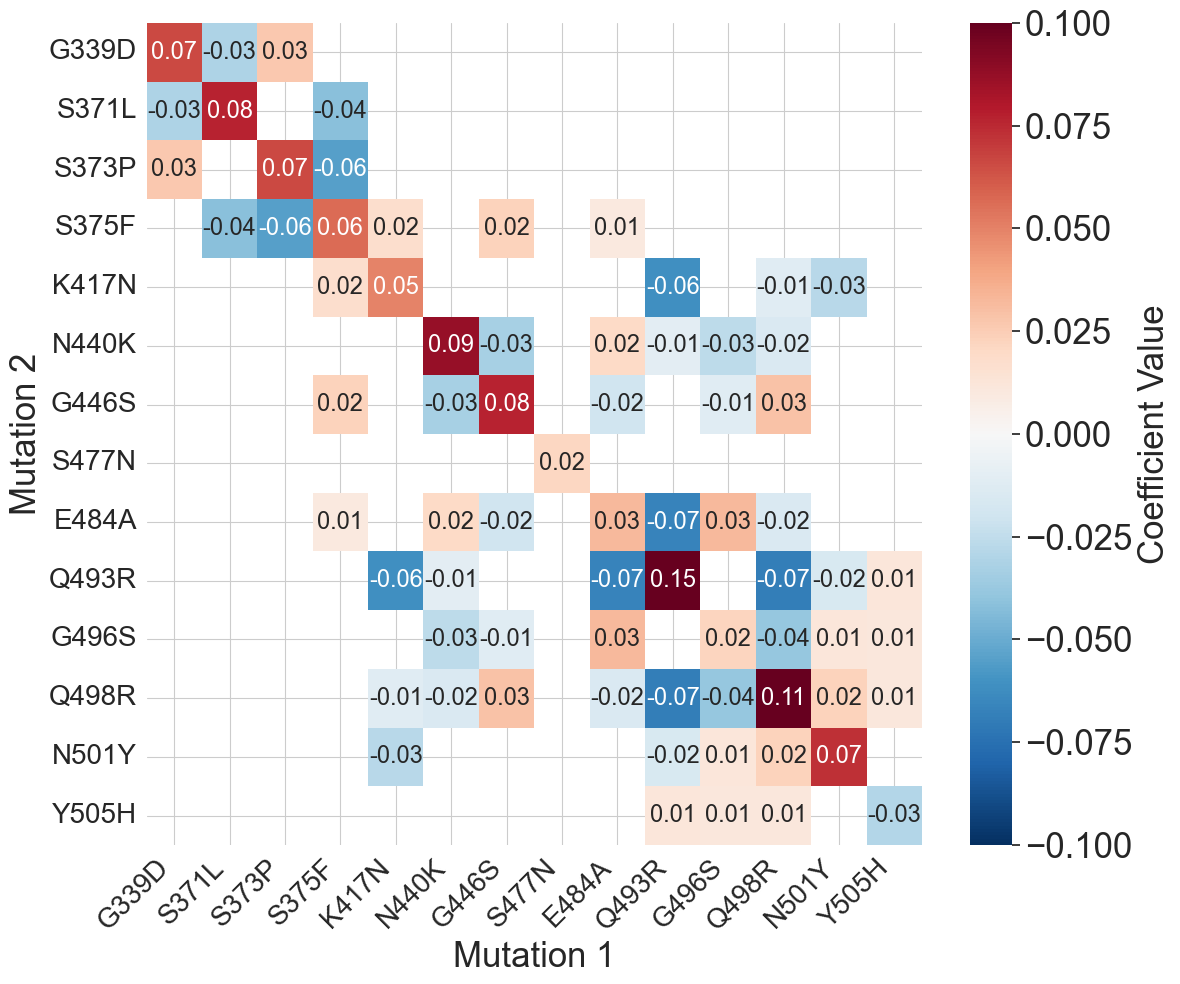

In [14]:

coeff_l=regr_2nd.coef_
mat=epi_to_matrix(coeff_l)

#truncate by removing index 8 in mutation names and in the matrix: removed T478K
mutation_names_trunc=mutation_names[:8]+mutation_names[9:]
mat_trunc=np.delete(mat,8,0)
mat_trunc=np.delete(mat_trunc,8,1)

# Remove zero coefficients
mat_trunc = np.where(np.abs(mat_trunc)<0.01, 0, mat_trunc)

# Create a mask for zero values to avoid displaying them in the heatmap
mask = np.abs(mat_trunc) < 0.01

fig, ax = plt.subplots(figsize=(12, 10))
sns.set_theme(style="white")
heatmap = sns.heatmap(mat_trunc, annot=True, fmt='.2f', cmap='RdBu_r', 
                      vmin=-0.1, vmax=0.1, mask=mask, annot_kws={"size": 17})
plt.xticks(np.arange(14) + 0.5, mutation_names_trunc, rotation=45, ha='right', fontsize=20)
plt.yticks(np.arange(14) + 0.5, mutation_names_trunc, rotation=0, ha='right', fontsize=20)
cbar = heatmap.collections[0].colorbar
cbar.set_label('Coefficient Value', fontsize=25)
cbar.ax.tick_params(labelsize=25)
plt.xlabel('Mutation 1', fontsize=25)
plt.ylabel('Mutation 2', fontsize=25)
plt.tight_layout()

plt.savefig('../paper/log_epistasis.png', dpi=300, bbox_inches='tight')

plt.show()


In [16]:
mat=epi_to_matrix(coeff_l)


In [17]:

actual_values = np.array(predicted_dataset['pred_f'].to_list())

# Predictions from the first-order model
predictions_first_order = regr_1st.predict(np.array(predicted_dataset['binary'].to_list()))

# Predictions from the second-order model
predictions_second_order = regr_2nd.predict(np.array(predicted_dataset['binary_epi'].to_list()))

# Calculate RSS for both models
rss_first_order = np.sum((actual_values - predictions_first_order) ** 2)
rss_second_order = np.sum((actual_values - predictions_second_order) ** 2)

# Number of observations and parameters in each model
n = len(actual_values)
p1 = 16  # Number of parameters in the first-order model
p2 = 121  # Number of parameters in the second-order model

# Calculate the F-statistic
numerator = (rss_first_order - rss_second_order) / (p2 - p1)
denominator = rss_second_order / (n - p2)
F_statistic = numerator / denominator

# Calculate the p-value
from scipy.stats import f
dfn = p2 - p1  # Degrees of freedom for the numerator
dfd = n - p2  # Degrees of freedom for the denominator
p_value = 1 - f.cdf(F_statistic, dfn, dfd)

print("F-statistic:", F_statistic)
print("p-value:", p_value)


F-statistic: 540.2511868277633
p-value: 1.1102230246251565e-16


# Distance between residues

In [18]:
def read_pdb_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    return lines


# Provide the file path to your PDB file
file_path = '../data/6m0j.pdb'
lines = read_pdb_file(file_path)
CHAIN = 'E'

    

def get_average_coordinates(lines, residue_name, residue_chain, residue_number):
    coordinates = []
    count = 0

    for line in lines:
        if line.startswith('ATOM'):
            columns = line.split()
            if (
                columns[3] == residue_name and
                columns[4] == residue_chain and
                int(columns[5]) == residue_number
            ):
                coord = [float(columns[6]), float(columns[7]), float(columns[8])]
                coordinates.append(coord)
                count += 1

    if count > 0:
        print(f'Found {count} atoms for residue {residue_name} {residue_chain} {residue_number}')
        avg_coordinates = [sum(coords) / count for coords in zip(*coordinates)]
        return avg_coordinates
    else:
        print(f'No atoms found for residue {residue_name} {residue_chain} {residue_number}')
        return None
    


In [19]:
def decode_mutation(mutation_code):
    amino_acids = {
        'A': 'ALA', 'B': 'ASX', 'C': 'CYS', 'D': 'ASP', 'E': 'GLU', 'F': 'PHE', 'G': 'GLY', 'H': 'HIS', 'I': 'ILE',
        'K': 'LYS', 'L': 'LEU', 'M': 'MET', 'N': 'ASN', 'P': 'PRO', 'Q': 'GLN', 'R': 'ARG', 'S': 'SER', 'T': 'THR',
        'U': 'SEC', 'V': 'VAL', 'W': 'TRP', 'X': 'XAA', 'Y': 'TYR', 'Z': 'GLX'
    }

    original_aa = amino_acids.get(mutation_code[0], 'Unknown')
    position = int(mutation_code[1:-1])
    mutated_aa = amino_acids.get(mutation_code[-1], 'Unknown')

    return original_aa, position, mutated_aa


In [20]:
coordinates_array = np.zeros((len(mutation_names), 3))
for mutation in mutation_names:
    original_aa, position, mutated_aa = decode_mutation(mutation)
    coordinates = get_average_coordinates(lines, original_aa, CHAIN, position)
    coordinates_array[mutation_names.index(mutation)] = coordinates
#remove the 8th mutation T478K
coordinates_array_trunc=np.delete(coordinates_array,8,0)
coordinates_array_trunc

Found 4 atoms for residue GLY E 339
Found 6 atoms for residue SER E 371
Found 6 atoms for residue SER E 373
Found 6 atoms for residue SER E 375
Found 9 atoms for residue LYS E 417
Found 8 atoms for residue ASN E 440
Found 4 atoms for residue GLY E 446
Found 6 atoms for residue SER E 477
Found 7 atoms for residue THR E 478
Found 9 atoms for residue GLU E 484
Found 3 atoms for residue GLN E 493
Found 4 atoms for residue GLY E 496
Found 9 atoms for residue GLN E 498
Found 8 atoms for residue ASN E 501
Found 12 atoms for residue TYR E 505


array([[-37.5935    ,  14.21375   ,  30.79325   ],
       [-27.0935    ,   7.619     ,  26.77416667],
       [-28.22666667,   9.081     ,  22.484     ],
       [-24.7955    ,  13.98683333,  18.19683333],
       [-30.04122222,  33.51044444,   9.614     ],
       [-37.83075   ,   9.842625  ,  14.381875  ],
       [-44.76425   ,  16.24075   ,   2.59075   ],
       [-38.71116667,  52.722     ,   1.83683333],
       [-46.06633333,  39.53322222,   2.52055556],
       [-39.712     ,  30.346     ,   8.59466667],
       [-39.12925   ,  21.229     ,   5.70375   ],
       [-39.246     ,  16.30433333,   3.837     ],
       [-34.256875  ,  15.66525   ,   3.882375  ],
       [-31.04033333,  20.53841667,   4.53208333]])

In [21]:
#compute the distance matrix
from scipy.spatial import distance_matrix
dist_matrix_trunc = distance_matrix(coordinates_array_trunc, coordinates_array_trunc)

In [22]:
#create mattrix of cross names of mutations
cross_names_matrix=np.zeros((14,14),dtype='object')
for i in mutation_names_trunc:
    for j in mutation_names_trunc:
        cross_names_matrix[mutation_names_trunc.index(i),mutation_names_trunc.index(j)]=i+'-'+j

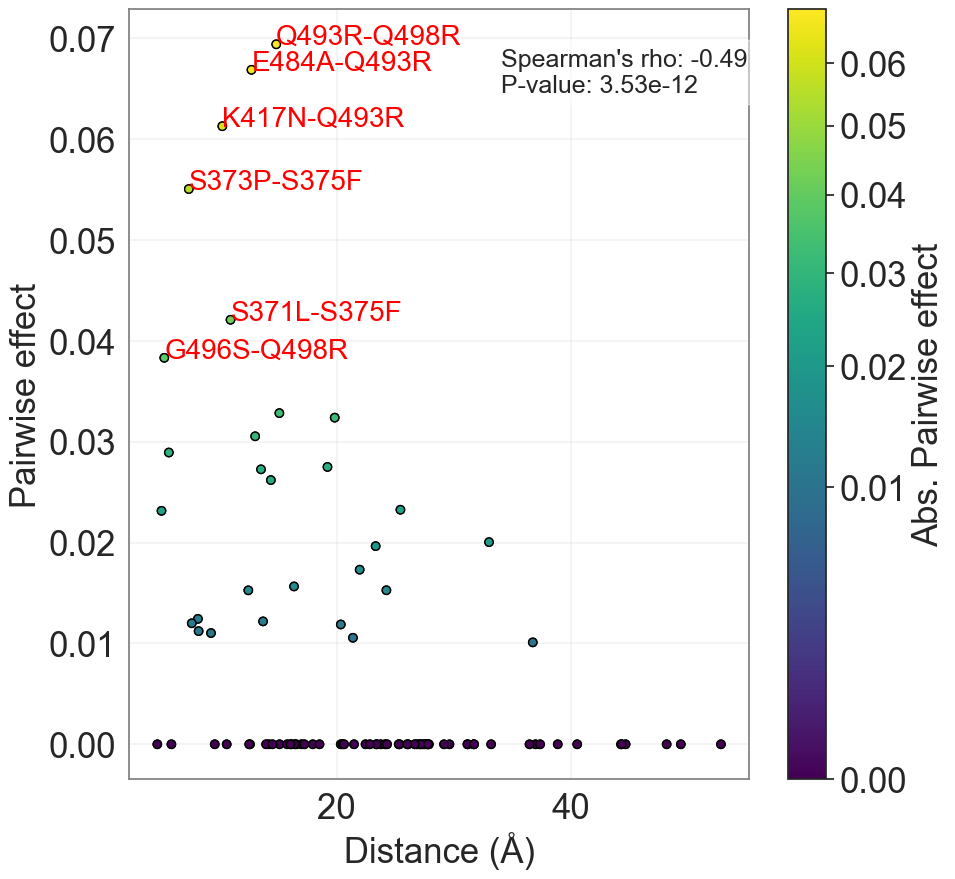

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

sns.set_theme(style="white")

# keep index where the distance is not 0
nonzero_indices = dist_matrix_trunc != 0

# Prepare data
dist_values = dist_matrix_trunc[nonzero_indices]
epi_values = abs(mat_trunc[nonzero_indices])


# Compute Spearman's rank correlation coefficient
spearman_corr, spearman_p = spearmanr(dist_values, epi_values)
spearman_text = f"Spearman's rho: {spearman_corr:.2f}\nP-value: {spearman_p:.2e}"

# plot the values inside the distance matrix vs the absolute values inside the epistasis matrix
fig, ax = plt.subplots(figsize=(10, 10))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

sc = ax.scatter(dist_values, epi_values,
                c=epi_values, cmap='viridis', norm=mcolors.PowerNorm(gamma=0.5), edgecolor='black')

# annotate points with high epistasis coefficient
for i in range(14):
    for j in range(i, 14):
        if dist_matrix_trunc[i, j] != 0 and abs(mat_trunc[i, j]) > 0.037:
            ax.annotate(cross_names_matrix[i, j], (dist_matrix_trunc[i, j], abs(mat_trunc[i, j])), fontsize=20, color='red')

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('Abs. Pairwise effect', size=25)
cbar.ax.tick_params(labelsize=25)

ax.set_xlabel('Distance (Å)', fontsize=25)
ax.set_ylabel('Pairwise effect', fontsize=25)
ax.text(0.6, 0.95,  spearman_text, transform=ax.transAxes, fontsize=18, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

ax.grid(True, color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray') 
ax.spines['right'].set_color('gray')
ax.spines['left'].set_color('gray')

ax.tick_params(axis='both', which='major', labelsize=25)

plt.savefig('../paper/log_distance_vs_epistasis.png', dpi=300, bbox_inches='tight')

plt.show()
